# Criminal Records

Imagine a work in Town Hall of a city. Your job is to investigate the best locals to send policy. However, to do it, you need to present solid arguments to others. So, I choose to investigate the criminal records and, based on it, construct models that can predict the type of crime basead on the locals. This way, police can be alocated.

# Data import description

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

print('Libraries imported.')

Libraries imported.


In [2]:
# load data
data = pd.read_csv('http://samplecsvs.s3.amazonaws.com/SacramentocrimeJanuary2006.csv')
data.head(11)

,cdatetime,address,district,beat,grid,crimedescr,ucr_ncic_code,latitude,longitude
0,1/1/06 0:00,3108 OCCIDENTAL DR,3,3C,1115,10851(A)VC TAKE VEH W/O OWNER,2404,38.550420,-121.391416
1,1/1/06 0:00,2082 EXPEDITION WAY,5,5A,1512,459 PC BURGLARY RESIDENCE,2204,38.473501,-121.490186
2,1/1/06 0:00,4 PALEN CT,2,2A,212,10851(A)VC TAKE VEH W/O OWNER,2404,38.657846,-121.462101
3,1/1/06 0:00,22 BECKFORD CT,6,6C,1443,476 PC PASS FICTICIOUS CHECK,2501,38.506774,-121.426951
4,1/1/06 0:00,3421 AUBURN BLVD,2,2A,508,459 PC BURGLARY-UNSPECIFIED,2299,38.637448,-121.384613
5,1/1/06 0:00,5301 BONNIEMAE WAY,6,6B,1084,530.5 PC USE PERSONAL ID INFO,2604,38.526979,-121.451338
6,1/1/06 0:00,2217 16TH AVE,4,4A,957,459 PC BURGLARY VEHICLE,2299,38.537173,-121.487577
7,1/1/06 0:00,3547 P ST,3,3C,853,484 PC PETTY THEFT/INSIDE,2308,38.564335,-121.461883
8,1/1/06 0:00,3421 AUBURN BLVD,2,2A,508,459 PC BURGLARY BUSINESS,2203,38.637448,-121.384613
9,1/1/06 0:00,1326 HELMSMAN WAY,1,1B,444,1708 US THEFT OF MAIL,2310,38.609602,-121.491838


In [3]:
data.head()

,cdatetime,address,district,beat,grid,crimedescr,ucr_ncic_code,latitude,longitude
0,1/1/06 0:00,3108 OCCIDENTAL DR,3,3C,1115,10851(A)VC TAKE VEH W/O OWNER,2404,38.550420,-121.391416
1,1/1/06 0:00,2082 EXPEDITION WAY,5,5A,1512,459 PC BURGLARY RESIDENCE,2204,38.473501,-121.490186
2,1/1/06 0:00,4 PALEN CT,2,2A,212,10851(A)VC TAKE VEH W/O OWNER,2404,38.657846,-121.462101
3,1/1/06 0:00,22 BECKFORD CT,6,6C,1443,476 PC PASS FICTICIOUS CHECK,2501,38.506774,-121.426951
4,1/1/06 0:00,3421 AUBURN BLVD,2,2A,508,459 PC BURGLARY-UNSPECIFIED,2299,38.637448,-121.384613


This dataset contains rows that describe crime occurrency.  It is splited in 9 columns:
- cdatetime is the date when the event occours;
- addres is the address where the event occours;
- district is a number id of the district;
- beat, grid, latiture and longitude are used to point exactly the place of the event;
- crimedescr is a string which describe the crime itself;
- ucr_ncic_code is the crime code

In [4]:
data.shape

(7584, 9)

The data contains 7584 rows of crime events.

In [5]:
data.dtypes

cdatetime         object
address           object
district           int64
beat              object
grid               int64
crimedescr        object
ucr_ncic_code      int64
latitude         float64
longitude        float64
dtype: object

# Methodology - Clear and preprocess dataset

In [6]:
# convert cdatatime to datetime
data['cdatetime'] = pd.to_datetime(data.cdatetime)
# split cdatetime into date and time columns. It will be used to know the turn which the event occours
data['turn'] = [d.time() for d in data['cdatetime']]
data['cdatetime'] = [d.date() for d in data['cdatetime']]
# discretize turn column
time = pd.to_datetime(data['turn'], format='%H:%M:%S').dt.hour
data['turn'] = pd.cut(time, 
                    bins=[0,6,12,18,24], 
                    include_lowest=True, 
                    labels=['dawn','morning','evening','night'])
#  categorize ucr_ncic_code
data["ucr_ncic_code"] = data["ucr_ncic_code"].astype('category').cat.codes

# see result
data.head()

,cdatetime,address,district,beat,grid,crimedescr,ucr_ncic_code,latitude,longitude,turn
0,2006-01-01,3108 OCCIDENTAL DR,3,3C,1115,10851(A)VC TAKE VEH W/O OWNER,26,38.550420,-121.391416,dawn
1,2006-01-01,2082 EXPEDITION WAY,5,5A,1512,459 PC BURGLARY RESIDENCE,13,38.473501,-121.490186,dawn
2,2006-01-01,4 PALEN CT,2,2A,212,10851(A)VC TAKE VEH W/O OWNER,26,38.657846,-121.462101,dawn
3,2006-01-01,22 BECKFORD CT,6,6C,1443,476 PC PASS FICTICIOUS CHECK,27,38.506774,-121.426951,dawn
4,2006-01-01,3421 AUBURN BLVD,2,2A,508,459 PC BURGLARY-UNSPECIFIED,15,38.637448,-121.384613,dawn


In [7]:
data.dtypes

cdatetime          object
address            object
district            int64
beat               object
grid                int64
crimedescr         object
ucr_ncic_code        int8
latitude          float64
longitude         float64
turn             category
dtype: object

## Understanding data

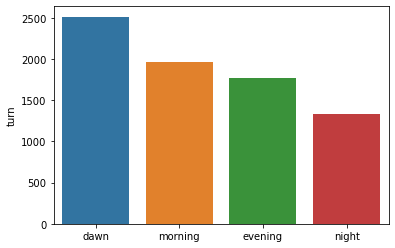

In [8]:
sns.barplot(x=data.turn.unique(), y=data.turn.value_counts())

We can see that most crimes occours in dawn and morning (2500 + ~2000 = 4500 of 7584 events). It can be used to determine the best turn to place policies. But, we can also see that all turn are dungerous, because none of them are below 1000 events of crime.
This type of plot can revel similar information for others columns, such as district and crime type.

In [9]:
data.ucr_ncic_code.value_counts().head(20)

83    2470
26     881
15     474
77     357
13     356
38     356
25     262
9      225
18     176
6      146
22     140
12     135
78     133
49     129
79     105
8       99
34      97
33      94
40      66
47      58
Name: ucr_ncic_code, dtype: int64

If we observe top 20 crime types, we will see that crime type 83 is the most commited.

# Results and discussion

With this analyse, we can alocate policy to the locals where the crimes 83, 26, 15, 77, and 13 occour.

In [10]:
crime_codes = ['83', '26', '15', '77', '13']
df_locals = data[data.ucr_ncic_code.isin(crime_codes)]

df_locals.address.value_counts().head(20)

3555 AUBURN BLVD                 46
2750 SUTTERVILLE RD              25
1689 ARDEN WAY                   17
FRANKLIN BLVD / FRUITRIDGE RD    16
5770 FREEPORT BLVD               16
2250 68TH AVE                    15
5303 FRANKLIN BLVD               14
MACK RD / VALLEY HI DR           10
3550 MARYSVILLE BLVD             10
715 L ST                         10
6879 14TH AVE                    10
1701 SUTTERVILLE RD               9
3301 FONG RANCH RD                9
7767 LA RIVIERA DR                9
6715 GLORIA DR                    9
15 CARTHAGE CT                    8
MARYSVILLE BLVD / ARCADE BLVD     8
BROADWAY / STOCKTON BLVD          8
4100 NORTHGATE BLVD               8
545 K ST                          7
Name: address, dtype: int64

The top 11 are the address with more need.

In [11]:
df_locals.address.value_counts().head(11)

3555 AUBURN BLVD                 46
2750 SUTTERVILLE RD              25
1689 ARDEN WAY                   17
FRANKLIN BLVD / FRUITRIDGE RD    16
5770 FREEPORT BLVD               16
2250 68TH AVE                    15
5303 FRANKLIN BLVD               14
MACK RD / VALLEY HI DR           10
3550 MARYSVILLE BLVD             10
715 L ST                         10
6879 14TH AVE                    10
Name: address, dtype: int64

# Conclusion

We can send policies to this 11 address and it should reduce the crime records of the next month. It is just possible because of the analysis we made.